In this notebook we're going to explore data from a Basketball Fantasy league that I play. We'll try to better understand the features that make a player valuable, and try to predict their contract for next season

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
df = pd.read_pickle('/content/drive/MyDrive/Datasets/Portfolio_datasets/Fantasy/fantasyPlayers.pkl')

In [43]:
df.head(5)

,Player,MINS,PTS,FGA,FTA,DR,OR,AST,TO,STL,BLK,PF,FPG,FPM,Contract,Duration
0,Nikola Jokic,36.35,27.52,18.78,5.70,8.39,3.09,8.48,3.61,1.61,0.65,3.04,36.10,0.99,"$25,000,000",3 anos\n36.10FPG
1,Luka Doncic,35.17,27.79,20.96,8.04,7.79,0.92,9.29,4.21,1.04,0.63,1.96,32.30,0.92,"$5,000,000",2 anos\n32.30FPG
2,Joel Embiid,32.37,29.32,16.79,11.26,8.95,1.74,2.68,3.32,1.32,1.21,2.37,32.15,0.99,"$18,000,000",2 anos\n32.15FPG
3,Giannis Antetokounmpo,32.96,27.26,18.04,9.74,9.39,1.70,5.57,3.65,0.96,1.26,3.04,31.67,0.96,"$25,000,000",1 anos\n31.67FPG
4,Karl Anthony Towns,33.00,22.00,15.75,6.25,8.50,4.00,4.25,2.50,0.50,2.75,2.75,31.10,0.94,"$18,000,000",3 anos\n31.10FPG


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    510 non-null    object 
 1   MINS      510 non-null    float64
 2   PTS       510 non-null    float64
 3   FGA       510 non-null    float64
 4   FTA       510 non-null    float64
 5   DR        510 non-null    float64
 6   OR        510 non-null    float64
 7   AST       510 non-null    float64
 8   TO        510 non-null    float64
 9   STL       510 non-null    float64
 10  BLK       510 non-null    float64
 11  PF        510 non-null    float64
 12  FPG       510 non-null    float64
 13  FPM       510 non-null    float64
 14  Contract  510 non-null    object 
 15  Duration  510 non-null    object 
dtypes: float64(13), object(3)
memory usage: 63.9+ KB


Firstly we can see that both 'Contract' and 'Duration' are currently as strings, which we don't want, therefore, let's correct this.

In [45]:
df.loc[:, 'Contract'] = df.Contract.apply(lambda x: ''.join(x.split('$', 1)))
df.loc[:, 'Contract'] = df.Contract.apply(lambda x: x.split(',', 1)[0])
df.loc[:, 'Contract'] = df.Contract.apply(lambda x: float(x))

df.loc[:, 'Duration'] = df.Duration.apply(lambda x: x.split('\n')[0].split(' ')[0])
df.loc[:, 'Duration'] = df.Duration.apply(lambda x: int(x))
df['Total_Contract'] = df['Contract'] * df['Duration']

In [46]:
df.head(5)

,Player,MINS,PTS,FGA,FTA,DR,OR,AST,TO,STL,BLK,PF,FPG,FPM,Contract,Duration,Total_Contract
0,Nikola Jokic,36.35,27.52,18.78,5.70,8.39,3.09,8.48,3.61,1.61,0.65,3.04,36.10,0.99,25.0,3,75.0
1,Luka Doncic,35.17,27.79,20.96,8.04,7.79,0.92,9.29,4.21,1.04,0.63,1.96,32.30,0.92,5.0,2,10.0
2,Joel Embiid,32.37,29.32,16.79,11.26,8.95,1.74,2.68,3.32,1.32,1.21,2.37,32.15,0.99,18.0,2,36.0
3,Giannis Antetokounmpo,32.96,27.26,18.04,9.74,9.39,1.70,5.57,3.65,0.96,1.26,3.04,31.67,0.96,25.0,1,25.0
4,Karl Anthony Towns,33.00,22.00,15.75,6.25,8.50,4.00,4.25,2.50,0.50,2.75,2.75,31.10,0.94,18.0,3,54.0


In [47]:
#checking for duplicated values
duplicateRowsDF = df[df.duplicated()]

print('There are', len(duplicateRowsDF), 'duplicated values')

There are 1 duplicated values


In [48]:
#dropping duplicated values
df.drop_duplicates(inplace=True)

duplicateRowsDF = df[df.duplicated()]
print('There are', len(duplicateRowsDF), 'duplicated values')

There are 0 duplicated values


In [49]:
#checking for missing values
df.isna().sum()

Player            0
MINS              0
PTS               0
FGA               0
FTA               0
DR                0
OR                0
AST               0
TO                0
STL               0
BLK               0
PF                0
FPG               0
FPM               0
Contract          0
Duration          0
Total_Contract    0
dtype: int64

## EDA

1) Selecting relevant observations

2) Perform EDA

In [50]:
no_players = df.shape[0]

In [51]:
#selecting relevant observations
#since our goal is to predict future contracts, we want to do this on players that really matters
df = df[(df['MINS'] > 0) &
        (df['FPM'] > 0.15) &
        (df['FPG'] > 7)] 

In [52]:
no_players_aft = df.shape[0]

print(no_players - no_players_aft, 'players were cutted')

227 players were cutted


In [53]:
df.describe()

,MINS,PTS,FGA,FTA,DR,OR,AST,TO,STL,BLK,PF,FPG,FPM,Contract,Duration,Total_Contract
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,26.321312,12.733511,10.015816,2.534894,3.866667,1.097128,2.827376,1.521348,0.828014,0.562518,2.073865,14.493901,0.539113,6.478723,2.365248,17.255319
std,6.169462,6.190505,4.489693,1.888441,1.790699,0.852884,1.983551,0.854269,0.384357,0.496451,0.647018,6.277932,0.142742,6.904115,1.134040,21.311920
min,10.000000,3.330000,2.200000,0.000000,0.870000,0.000000,0.000000,0.110000,0.000000,0.000000,0.470000,7.050000,0.310000,0.000000,0.000000,0.000000
25%,21.505000,8.085000,6.650000,1.130000,2.627500,0.500000,1.360000,0.912500,0.550000,0.220000,1.632500,9.620000,0.432500,1.000000,1.000000,3.000000
50%,26.775000,11.510000,9.060000,2.110000,3.460000,0.835000,2.130000,1.320000,0.795000,0.440000,2.040000,12.635000,0.510000,4.000000,2.000000,9.000000
75%,31.630000,15.860000,12.810000,3.165000,4.807500,1.480000,3.917500,1.930000,1.047500,0.747500,2.500000,17.347500,0.630000,9.000000,3.000000,22.750000
max,38.110000,33.170000,24.940000,11.260000,10.000000,4.800000,11.210000,4.920000,2.060000,3.640000,4.180000,36.100000,0.990000,25.000000,4.000000,100.000000


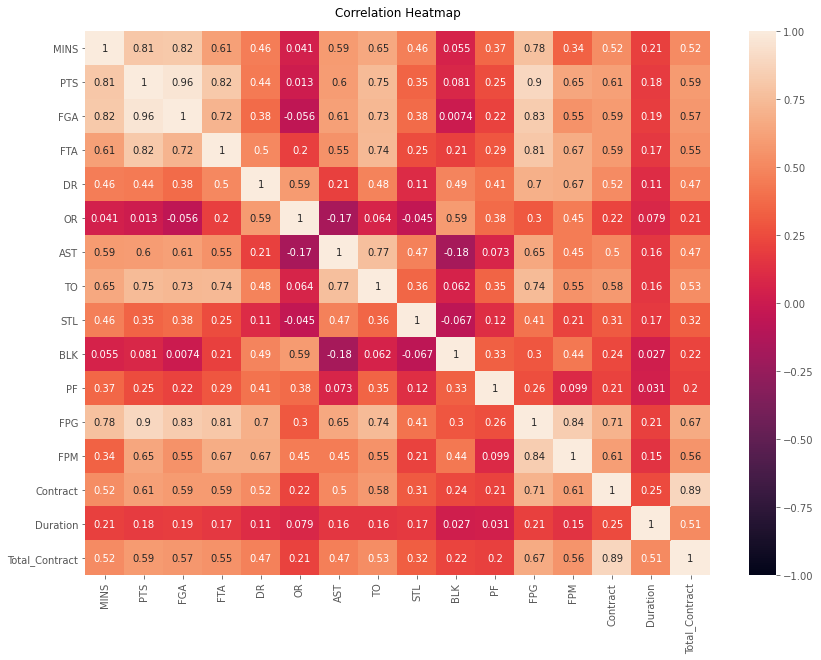

In [54]:
#correlation matrix
corr = df.corr()

plt.figure(figsize=(14,10))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=15);

As we expected, there is a great correlation between FPG and FPM, since they are functions of (almost) all the other variables

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


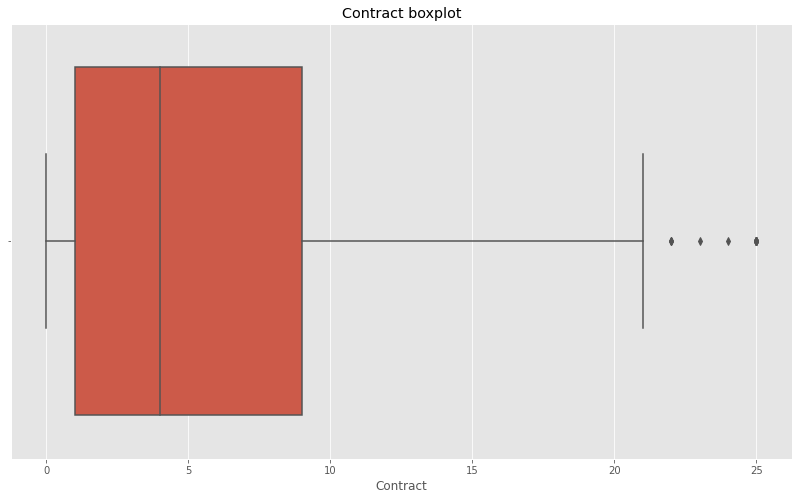

In [55]:
plt.figure(figsize=(14,8))
plt.title('Contract boxplot')
x = df['Contract']
ax = sns.boxplot(x)

In [56]:
np.median(x)

4.0

Another intereseting fact: the vast majority of players have low contracts, withe median 4. This suggests that we shouldn't spend too much time with high contracts.

Obs: Another fact that points out tha high contracts are not interesting, is that we usually know which players are gonna be top players, and therefore gain the max contract.

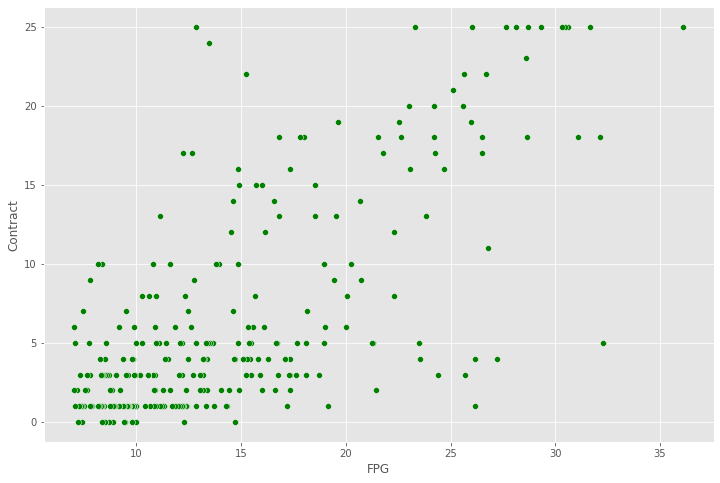

In [57]:
#FPG - Contract correlation

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.scatterplot(x="FPG", y="Contract", data=df, ax=ax, color = 'green')

As we can see above, it doesn't seem to be a linear correlation between FPG (fantasy points per game) and Contract, wich sounds very counterintuitive. What happens is that not everyone in the league has been good GM's, and also, basketball is an amazing sport, and not everything goes as we expected.

In [58]:
disappointment = df[df['Player'] == 'Blake Griffin']
unicorn = df[df['Player'] == 'Luka Doncic']
comparison = pd.concat([disappointment, unicorn])

comparison

,Player,MINS,PTS,FGA,FTA,DR,OR,AST,TO,STL,BLK,PF,FPG,FPM,Contract,Duration,Total_Contract
123,Blake Griffin,31.12,12.24,11.00,3.18,5.06,0.35,3.71,1.71,0.65,0.12,1.94,13.46,0.43,24.0,1,24.0
1,Luka Doncic,35.17,27.79,20.96,8.04,7.79,0.92,9.29,4.21,1.04,0.63,1.96,32.30,0.92,5.0,2,10.0


Obs: In our league, contracts range from 1 to 4 years. So Griffin may have been hired 3 years ago, back in 2018, when he had a great season(averaging 24.5, 5.4, 7.5), in his 2nd year in Detroit, but what we're missing, is that after this, he got injured.

Obs2: Since Doncic was for sure a top5 pick, during the 18-19 season, his contract is 4 year - 5M. But again, what we missed, is that Doncic has been showing potential to be the greatest Euro player in the league.

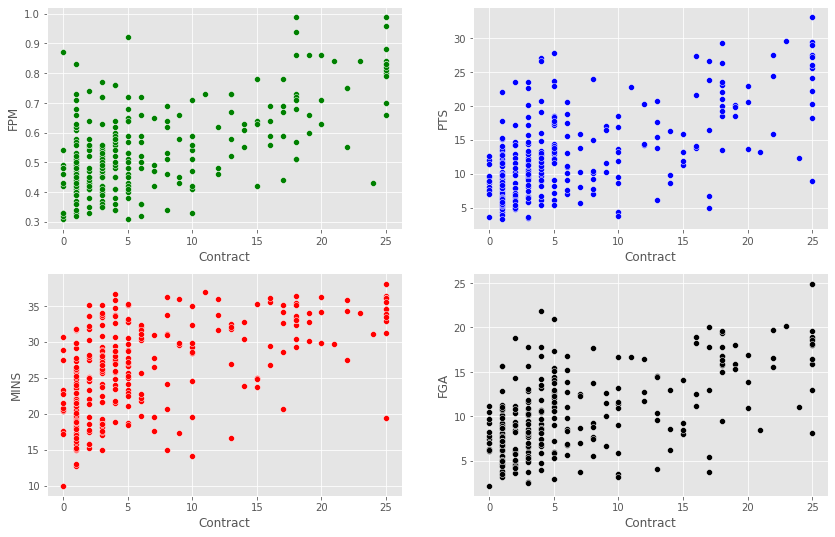

In [59]:
#There's any linear correlation between contract and other features ?

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

a = df['Contract']
b = df['FPM']
c = df['PTS']
d = df['MINS']
e = df['FGA']


# plot 1
sns.scatterplot(x=a, y=b, color='green', ax=axes[0,0])

# plot 2
sns.scatterplot(x=a, y=c, color='blue', ax=axes[0,1])

# plot 3
sns.scatterplot(x=a, y=d, color='red', ax=axes[1,0])

# plot 4
sns.scatterplot(x=a, y=e, color='black', ax=axes[1,1])

All of the plots above seem similar, but none of them show a linear correlation with the target variable.

In [60]:
#another real measure

df['FPG*FPM'] = df['FPG'] * df['FPM']
df['TSA'] = df['FGA'] + df['FTA'] * 0.44
df['TS%'] = df['PTS'] / (2 * df['TSA'])
df.sort_values(by='TS%', ascending=False).head(10)

,Player,MINS,PTS,FGA,FTA,DR,OR,AST,TO,STL,BLK,PF,FPG,FPM,Contract,Duration,Total_Contract,FPG*FPM,TSA,TS%
225,Juan Toscano-Anderson,21.09,5.64,3.36,0.55,4.45,0.27,2.00,0.91,0.45,0.64,2.09,9.17,0.43,1.0,1,1.0,3.9431,3.6020,0.782898
151,DeAndre Jordan,20.67,6.71,3.75,1.38,5.17,1.58,1.79,1.63,0.38,1.33,2.21,12.24,0.59,17.0,2,34.0,7.2216,4.3572,0.769990
171,Robert Williams III,15.29,5.94,3.65,0.88,3.29,2.24,0.71,1.12,0.94,1.24,1.47,11.27,0.74,2.0,2,4.0,8.3398,4.0372,0.735658
146,Ivica Zubac,19.92,8.00,4.48,2.32,4.32,2.28,1.00,0.96,0.40,0.88,2.44,12.39,0.62,1.0,2,2.0,7.6818,5.5008,0.727167
59,Jarrett Allen,26.17,11.54,6.04,4.38,6.04,2.79,1.54,1.38,0.46,1.71,1.71,18.72,0.72,3.0,1,3.0,13.4784,7.9672,0.724219
235,Tacko Fall,10.00,3.60,2.20,0.80,3.20,1.00,0.00,0.20,0.00,1.80,1.40,8.68,0.87,0.0,1,0.0,7.5516,2.5520,0.705329
104,Thomas Bryant,27.50,14.30,9.10,2.40,4.30,1.80,1.50,1.10,0.40,0.80,3.10,14.90,0.54,2.0,2,4.0,8.0460,10.1560,0.704017
266,Daniel Gafford,15.05,5.33,3.14,1.57,1.95,1.48,0.62,0.57,0.52,1.19,2.05,7.52,0.50,1.0,3,3.0,3.7600,3.8308,0.695677
162,Gorgui Dieng,19.00,8.50,5.44,1.56,3.56,1.44,1.56,1.19,0.94,0.81,1.81,11.83,0.62,1.0,2,2.0,7.3346,6.1264,0.693719
186,Wayne Ellington,25.20,12.73,8.87,0.80,1.73,0.47,1.20,0.87,0.53,0.20,1.47,10.65,0.42,1.0,2,2.0,4.4730,9.2220,0.690197


Look that even with more significative measures, like TS%, this new feature doesn't mean too much for us, because high TS% doesn't necessarily means a high impact in the game. 

In addition to this, FPG is a formula that takes into account all the simple measures of the game (PTS, MIN, ...) wich leads us to think that FPG will be the most (and unique) important feature for our model.

##Dimensionality Reductions

Let's try to perform a PCA transformation. PCA can potentially increase the performance of decision-trees based algorithms for example, therefore, it's a good bet. Besides that we'll also try LDA transformation, a combination of both and a simple plot of the two (probable) most importante features

### Pre-processing: outliers remotion and re-scaling

In [128]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

X = df.select_dtypes(include='number')
X.drop(['Contract'], axis=1, inplace=True)
Y = df['Contract']

Y = pd.cut(Y, bins=5, labels=["E", "D", "C", "B", "A"])
Y = labelencoder.fit_transform(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


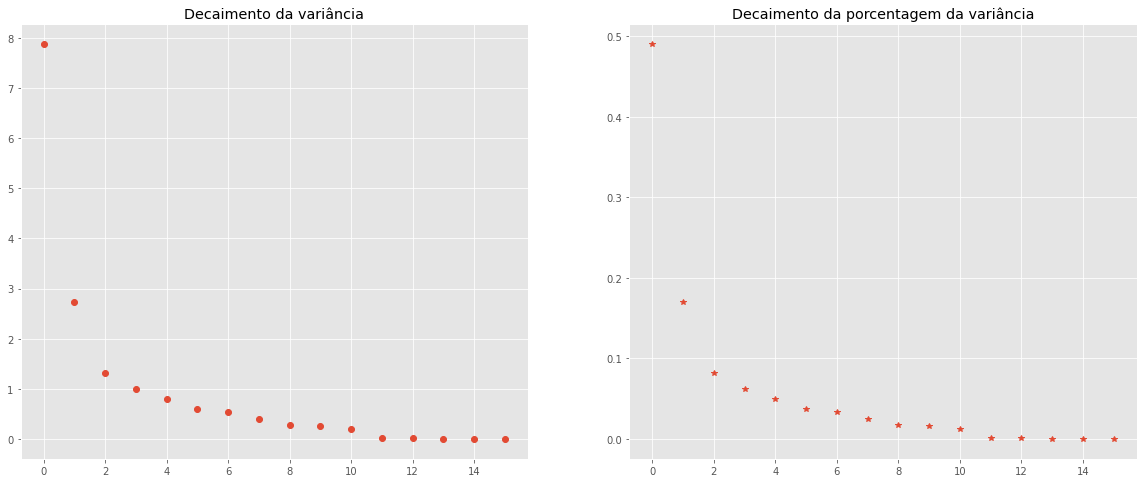

In [89]:
#Taking away outliers
Xzscore = stats.zscore(X,axis=0)
outliers = np.abs(Xzscore) > 2.8
outliers_id = np.argwhere(outliers == True)
temp = X
temp = temp.drop(outliers_id[:,0],axis=0)

X_no_outliers = temp.values

y_plot = np.delete(Y, outliers_id[:,0])
y_plot.shape

scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_no_outliers)

PCA_solver = PCA()
PCA_solver.fit(data_scaled)
no_Outliers_transformed = PCA_solver.fit(data_scaled)

X_no_outliers = pd.DataFrame(X_no_outliers, columns=X.columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set(title='Decaimento da variância')
ax1.plot(PCA_solver.explained_variance_, 'o')
ax2.set(title='Decaimento da porcentagem da variância')
ax2.plot(PCA_solver.explained_variance_ratio_, '*')

### PCA

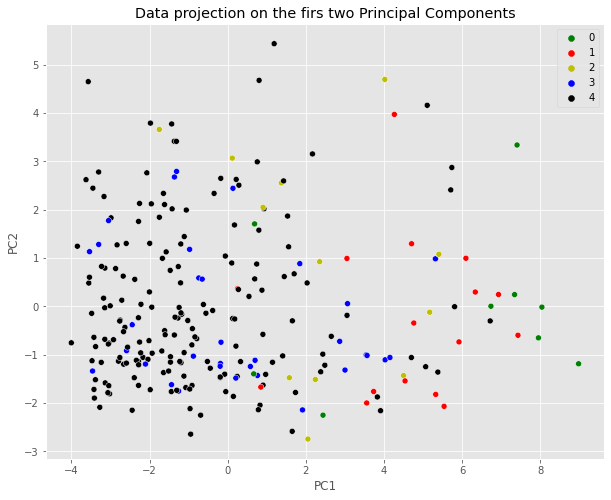

In [63]:
projection = PCA(n_components=2)
data2d = projection.fit_transform(data_scaled)

plt.style.use("ggplot")

plt.figure(figsize=(10,8))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data projection on the firs two Principal Components')
sns.scatterplot(x=data2d[:,0], y=data2d[:,1], hue=y_plot, palette=["g", "r", "y", "b", "k"])

### LDA

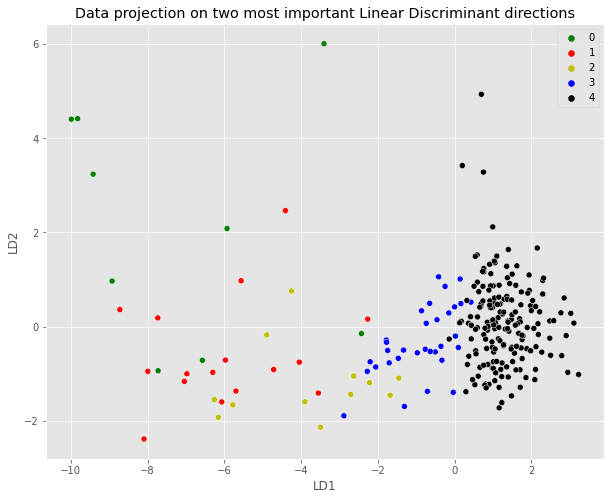

In [64]:
LDA = LinearDiscriminantAnalysis()
data_transformed = LDA.fit_transform(X_no_outliers, y_plot)

plt.figure(figsize=(10,8))
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Data projection on two most important Linear Discriminant directions')
sns.scatterplot(x=data_transformed[:,0], y=data_transformed[:,1], hue=y_plot, palette=["g", "r", "y", "b", "k"])

### PCA + LDA

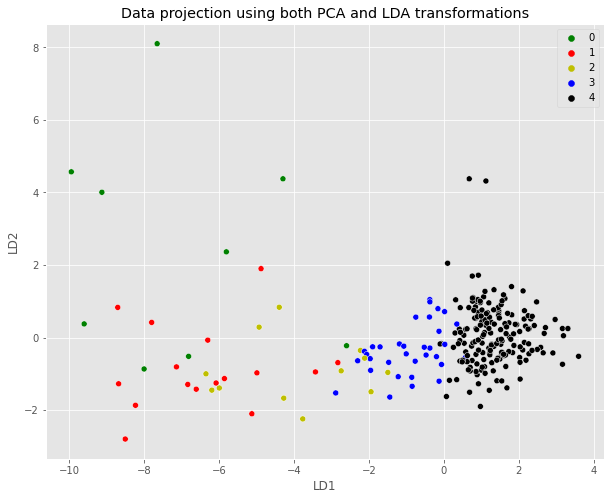

In [65]:
PCA_solver = PCA()
LDA = LinearDiscriminantAnalysis()
pcaData = PCA_solver.fit_transform(data_scaled)
PCALDA = LDA.fit_transform(pcaData, y_plot)

plt.figure(figsize=(10,8))
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Data projection using both PCA and LDA transformations')
sns.scatterplot(x=PCALDA[:,0], y=PCALDA[:,1], hue=y_plot, palette=["g", "r", "y", "b", "k"])


### Two (probable) most important features

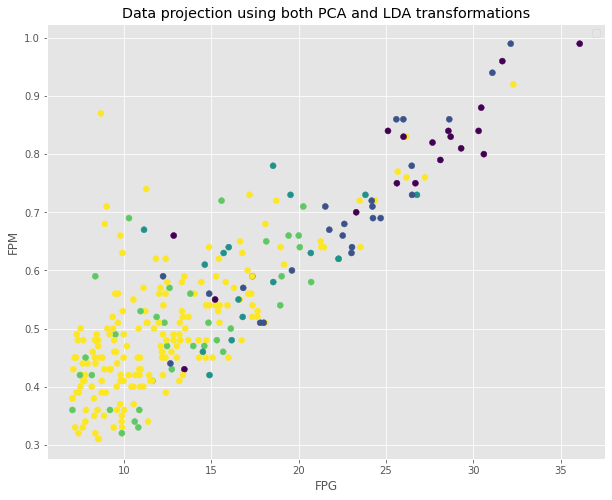

In [85]:
plt.figure(figsize=(10,8))
plt.xlabel('FPG')
plt.ylabel('FPM')
plt.title('Data projection on two most important features')
plt.scatter(x=df['FPG'], y=df['FPM'], c=Y)

With all these plots, since both LDA and PCA are linear dimensionality reductions, we can infer that the best segmentation for the data **isn't linear**

## Pre-Processing

Note that we don't need to know exactly the contract for the next season. If we transform our problem into a classfication problem, to know the range of the contract, the results will be pretty satisfatory.

This transformation was done previously, on the target variable 'contract'

In [103]:
from sklearn.feature_selection import SelectKBest, f_regression

fs = SelectKBest(score_func=f_regression, k=3)
X_selected = fs.fit_transform(X_no_outliers, y_plot)

cols = fs.get_support()
names = X_no_outliers.columns.values[cols]
scores = fs.scores_[cols]
names_scores = list(zip(names, scores))

names_scores

[('FPG', 129.04444450437728),
 ('FPG*FPM', 131.11857615234703),
 ('TSA', 98.75658449467304)]

In [104]:
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(X_selected, y_plot, stratify=y_plot, train_size=0.8)
x_train, x_validation, y_train, y_validation = train_test_split(x_temp, y_temp, stratify=y_temp, train_size=0.8)

## Model training


In [105]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

classifiers = [('lr', LogisticRegression(solver='newton-cg', multi_class='auto')), 
               ('dt', DecisionTreeClassifier()),
               ('knn', KNeighborsClassifier())]

vcs = VotingClassifier(classifiers, voting='soft')
vcs.fit(x_train, y_train)
print("Score validation:", vcs.score(x_validation, y_validation))
print("Score test:", vcs.score(x_test, y_test))

Score validation: 0.625
Score test: 0.64


In [107]:
from sklearn.metrics import accuracy_score
LR = LogisticRegression(solver='newton-cg', multi_class='auto')
LR.fit(x_train, y_train)

y_pred = LR.predict(x_validation)
print("Accuracy validation:",accuracy_score(y_validation, y_pred))
y_pred = LR.predict(x_test)
print("Accuracy test:", accuracy_score(y_test, y_pred))

Accuracy validation: 0.7
Accuracy test: 0.72


In [108]:
clf = DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_validation)
print("Accuracy validation:",accuracy_score(y_validation, y_pred))
y_pred = clf.predict(x_test)
print("Accuracy test:",accuracy_score(y_test, y_pred))

Accuracy validation: 0.7
Accuracy test: 0.64


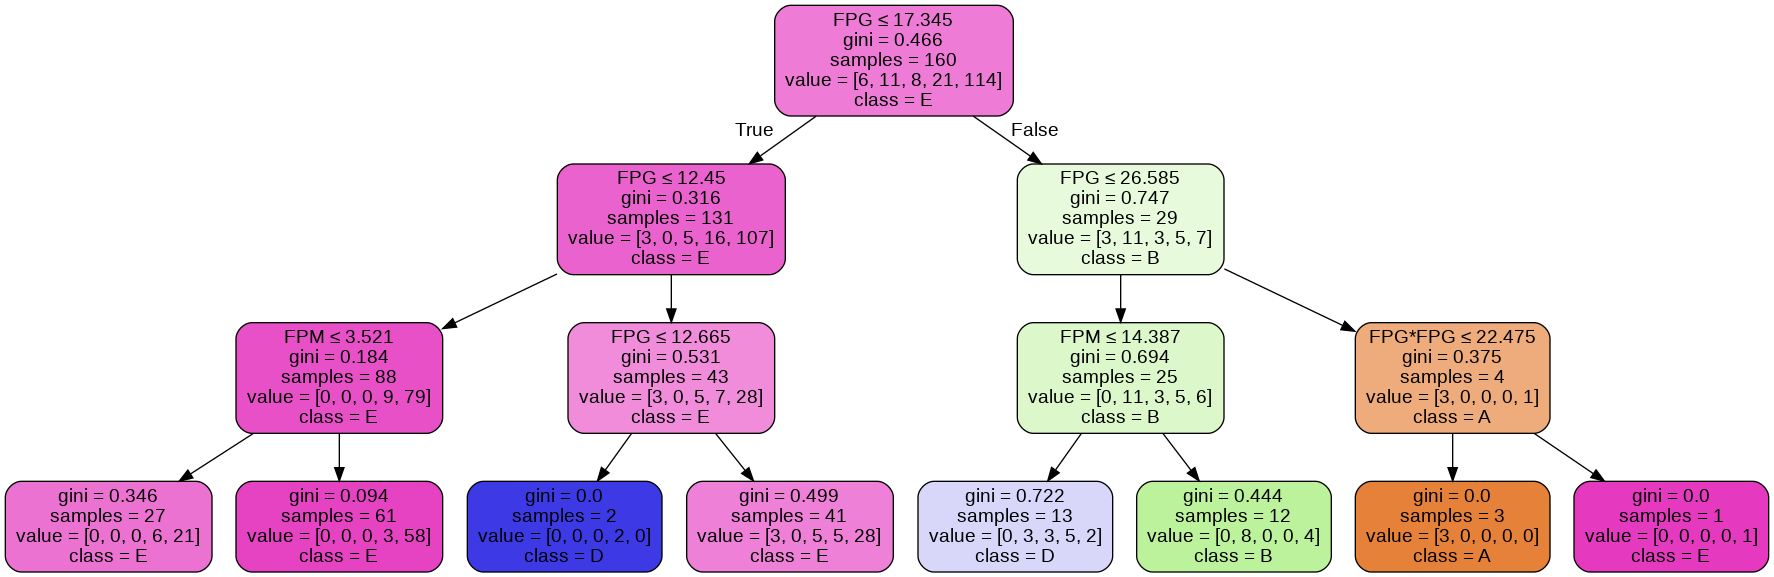

In [109]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

feature_names = ['FPG', 'FPM', 'FPG*FPG']

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names, class_names=['A', 'B', 'C', 'D', 'E'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisionTree.png')
Image(graph.create_png())

In [117]:
from sklearn.ensemble import RandomForestClassifier

rf200 = RandomForestClassifier(n_estimators=200, max_depth=3)
rf200.fit(x_train, y_train)
print("Score validation:", rf100.score(x_validation, y_validation))
print("Score test:", rf100.score(x_test, y_test))

Score validation: 0.725
Score test: 0.76


In [118]:
y_pred = rf200.predict(x_test)

As we can see, RandomForest was the model with the higher score, let's understand a bit more about its errors

In [131]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['0', '1', '2', '3', '4']
print(classification_report(y_test, y_pred,target_names=target_names))


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.40      0.67      0.50         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         7
           4       0.80      0.97      0.88        36

    accuracy                           0.76        50
   macro avg       0.44      0.43      0.41        50
weighted avg       0.64      0.76      0.69        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


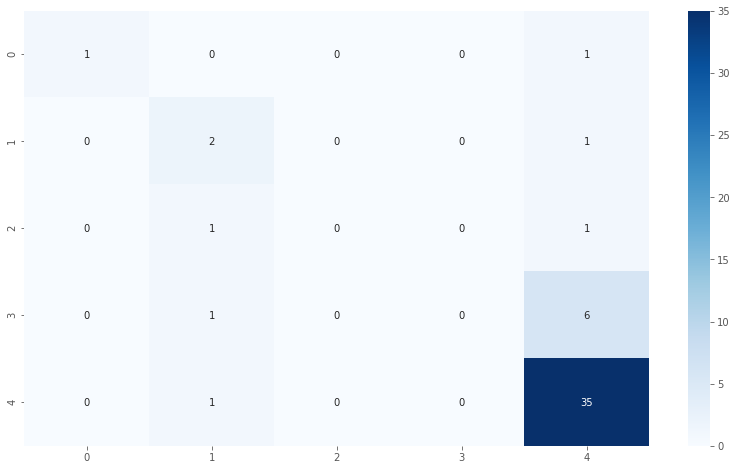

In [139]:
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14,8))
sns.heatmap(cf_matrix, annot=True, cmap='Blues')


The confusion matrix plot gives us a good intpretation of the results. As we can see, the worst kind of error did not occur, which would be if class 4 contracts were classified as class 0.

The overall result was good, but there's still room for improvements, such as:
- Non-linear dimensionaliy reduction technique
- Non-linear classifiers
- Unsuervised learning

These topics can be treated in futures publications, and a real test for the algorithm, since the next Fantasy season starts soon, and therefore we can predict the contracts and compare them to what was actually given.
